[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna(how="all")
C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pypfopt\expected_returns.py:56: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' t

Expected annual return: 22.9%
Annual volatility: 9.3%
Sharpe Ratio: 2.24
Pesos optimizados para minimizar la volatilidad:
OrderedDict({'AI.PA': 0.25447, 'EGLN.L': 0.61501, 'ROVI.MC': 0.0969, 'STRL': 0.01885, 'VU.PA': 0.01477})


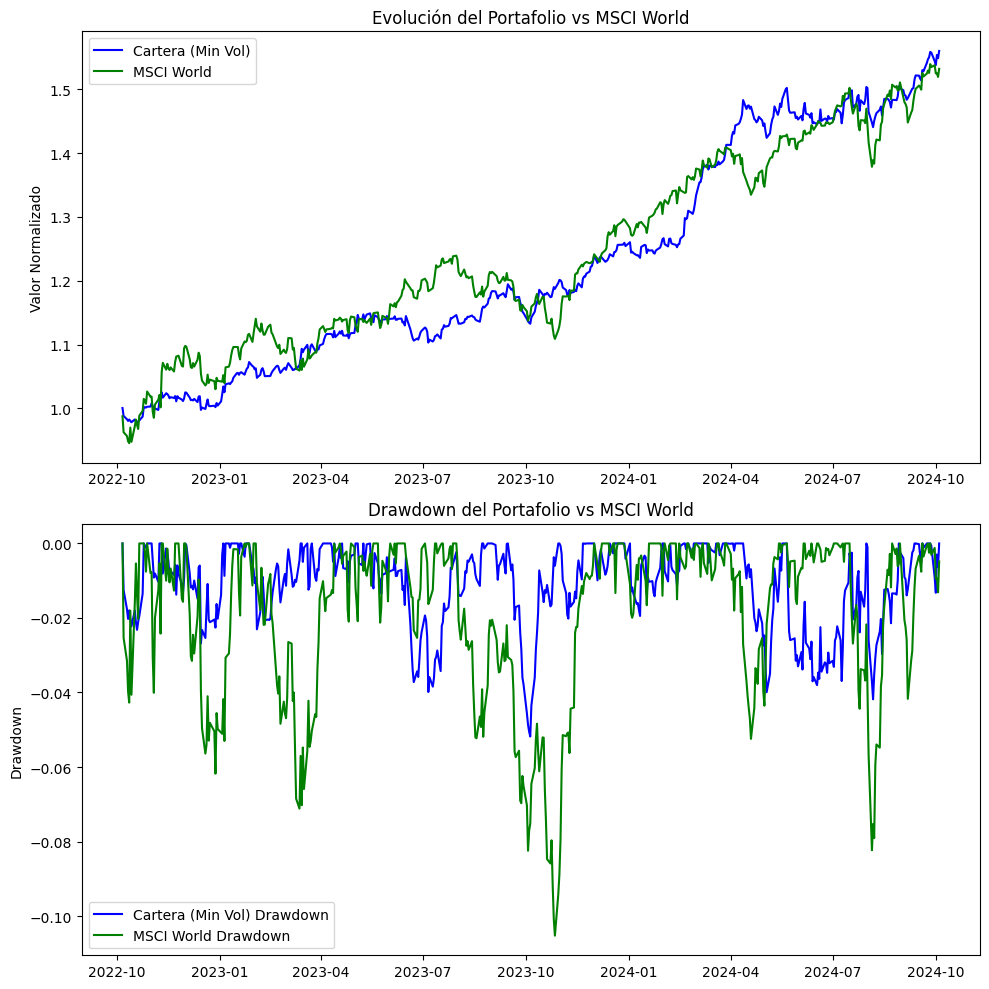

In [1]:
import yfinance as yf
from pypfopt import EfficientFrontier, risk_models, expected_returns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


tickers = ['AI.PA', 'STRL', 'VU.PA', 'ROVI.MC','EGLN.L']
msci_ticker = 'URTH'  # Usamos URTH como proxy del MSCI World

# Descarga de datos de precios de Yahoo Finance (últimos 2 años)
data = yf.download(tickers, period="2y")['Adj Close']
msci_data = yf.download(msci_ticker, period="2y")['Adj Close']

# Cálculo de los rendimientos esperados anuales y la matriz de covarianza
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

# Optimización para minimizar la volatilidad
ef = EfficientFrontier(mu, S)
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()

# Performance del portafolio optimizado
ef.portfolio_performance(verbose=True)

# Mostrar los pesos
print("Pesos optimizados para minimizar la volatilidad:")
print(cleaned_weights)

# 1. Calcular los rendimientos diarios del portafolio
daily_returns = data.pct_change().dropna()
weights_array = np.array(list(cleaned_weights.values()))
portfolio_returns = daily_returns.dot(weights_array)

# 2. Obtener los rendimientos diarios del MSCI World
msci_returns = msci_data.pct_change().dropna()

# 3. Calcular la evolución del valor de la cartera y el MSCI World
initial_investment = 1  # Podemos asumir una inversión inicial de 1 unidad monetaria

portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment
msci_value = (1 + msci_returns).cumprod() * initial_investment

# 4. Calcular el drawdown del portafolio y del MSCI World
def calculate_drawdown(value_series):
    """Calcula el drawdown a partir de una serie temporal de valores."""
    peak = value_series.cummax()
    drawdown = (value_series - peak) / peak
    return drawdown

portfolio_drawdown = calculate_drawdown(portfolio_value)
msci_drawdown = calculate_drawdown(msci_value)

# 5. Graficar la evolución de la cartera vs MSCI World y el drawdown
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Graficar la evolución de la cartera vs MSCI World
ax[0].plot(portfolio_value, label="Cartera (Min Vol)", color='blue')
ax[0].plot(msci_value, label="MSCI World", color='green')
ax[0].set_title('Evolución del Portafolio vs MSCI World')
ax[0].set_ylabel('Valor Normalizado')
ax[0].legend()

# Graficar el drawdown de la cartera vs MSCI World
ax[1].plot(portfolio_drawdown, label="Cartera (Min Vol) Drawdown", color='blue')
ax[1].plot(msci_drawdown, label="MSCI World Drawdown", color='green')
ax[1].set_title('Drawdown del Portafolio vs MSCI World')
ax[1].set_ylabel('Drawdown')
ax[1].legend()

plt.tight_layout()
plt.show()
